# Data Exploration - GTA Real Estate Hotspots

**Author:** Kyle Williamson (Data Engineer)  
**Date:** 2024-11-06  
**Purpose:** Initial exploration of collected data sources

## Objectives
1. Load and validate all data sources
2. Understand data structure and quality
3. Identify missing values and outliers
4. Generate summary statistics
5. Create initial visualizations

## Data Sources
- Toronto Open Data: Real estate, building permits, demographics
- OpenStreetMap: Road networks, POIs, transit stations

In [ ]:
# Standard libraries
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Geospatial
import geopandas as gpd
import folium
from folium import plugins

# Network analysis
import networkx as nx

# Add src to path
PROJECT_ROOT = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()

# Set paths
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
RESULTS = PROJECT_ROOT / 'results'

# Create results directories
(RESULTS / 'figures').mkdir(parents=True, exist_ok=True)
(RESULTS / 'tables').mkdir(parents=True, exist_ok=True)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Imports successful")
print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_RAW}")

Imports successful
Project root: /Users/kylewilliamson/Documents/gta-real-estate-hotspots
Data directory: /Users/kylewilliamson/Documents/gta-real-estate-hotspots/data/raw


## 1. Real Estate Data Exploration

Let's start by loading and exploring the real estate/housing data from Toronto Open Data.

In [2]:
# Find the most recent real estate file
real_estate_dir = DATA_RAW / 'real_estate'

if not real_estate_dir.exists():
    print("Real estate data not found. Run data collection first:")
    print("   python src/data_collection.py --sources real_estate")
else:
    # Get most recent file
    csv_files = list(real_estate_dir.glob('*.csv'))
    
    if csv_files:
        latest_file = max(csv_files, key=lambda p: p.stat().st_mtime)
        print(f"✓ Loading: {latest_file.name}")
        
        df_real_estate = pd.read_csv(latest_file)
        
        print(f"\n Dataset Shape: {df_real_estate.shape}")
        print(f"   Rows: {df_real_estate.shape[0]:,}")
        print(f"   Columns: {df_real_estate.shape[1]}")
        
        print(f"\n Columns:")
        for i, col in enumerate(df_real_estate.columns, 1):
            print(f"   {i:2d}. {col}")
        
        print(f"\n First few rows:")
        display(df_real_estate.head())
    else:
        print("No CSV files found in real_estate directory")

✓ Loading: real_estate_20251107.csv

 Dataset Shape: (2383, 146)
   Rows: 2,383
   Columns: 146

 Columns:
    1. _id
    2. Category
    3. Topic
    4. Data Source
    5. Characteristic
    6. City of Toronto
    7. Agincourt North
    8. Agincourt South-Malvern West
    9. Alderwood
   10. Annex
   11. Banbury-Don Mills
   12. Bathurst Manor
   13. Bay Street Corridor
   14. Bayview Village
   15. Bayview Woods-Steeles
   16. Bedford Park-Nortown
   17. Beechborough-Greenbrook
   18. Bendale
   19. Birchcliffe-Cliffside
   20. Black Creek
   21. Blake-Jones
   22. Briar Hill-Belgravia
   23. Bridle Path-Sunnybrook-York Mills
   24. Broadview North
   25. Brookhaven-Amesbury
   26. Cabbagetown-South St. James Town
   27. Caledonia-Fairbank
   28. Casa Loma
   29. Centennial Scarborough
   30. Church-Yonge Corridor
   31. Clairlea-Birchmount
   32. Clanton Park
   33. Cliffcrest
   34. Corso Italia-Davenport
   35. Danforth
   36. Danforth East York
   37. Don Valley Village
   38. Do

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


In [3]:
if 'df_real_estate' in locals():
    print("=" * 60)
    print("DATA QUALITY ASSESSMENT")
    print("=" * 60)
    
    # Missing values
    print("\n1. Missing Values:")
    missing = df_real_estate.isnull().sum()
    missing_pct = (missing / len(df_real_estate)) * 100
    missing_df = pd.DataFrame({
        'Missing_Count': missing,
        'Missing_Percentage': missing_pct
    }).sort_values('Missing_Count', ascending=False)
    
    print(missing_df[missing_df['Missing_Count'] > 0])
    
    # Data types
    print("\n2. Data Types:")
    print(df_real_estate.dtypes)
    
    # Summary statistics
    print("\n3. Summary Statistics:")
    display(df_real_estate.describe())
    
    # Check for duplicates
    duplicates = df_real_estate.duplicated().sum()
    print(f"\n4. Duplicate Rows: {duplicates}")
    
    # Date range (if Year column exists)
    if 'Year' in df_real_estate.columns:
        print(f"\n5. Year Range: {df_real_estate['Year'].min()} - {df_real_estate['Year'].max()}")

DATA QUALITY ASSESSMENT

1. Missing Values:
                          Missing_Count  Missing_Percentage
Lansing-Westgate                     56            2.349979
Lawrence Park North                  56            2.349979
North Riverdale                      56            2.349979
North St. James Town                 56            2.349979
Oakridge                             56            2.349979
...                                 ...                 ...
Eglinton East                        56            2.349979
Edenbridge-Humber Valley             56            2.349979
East End-Danforth                    56            2.349979
Lambton Baby Point                   56            2.349979
City of Toronto                       7            0.293747

[141 rows x 2 columns]

2. Data Types:
_id                         int64
Category                   object
Topic                      object
Data Source                object
Characteristic             object
                          

,_id
count,2383.000000
mean,1192.000000
std,688.057168
min,1.000000
25%,596.500000
50%,1192.000000
75%,1787.500000
max,2383.000000



4. Duplicate Rows: 0


## 2. Real Estate Visualizations

Let's visualize trends in the real estate data.

In [4]:
if 'df_real_estate' in locals() and 'Year' in df_real_estate.columns:
    # Check if we have price columns
    price_cols = [col for col in df_real_estate.columns if 'price' in col.lower() or 'value' in col.lower()]
    
    if price_cols:
        print(f"Found price columns: {price_cols}")
        
        # Create time series plot
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot 1: Average trends over time
        if len(price_cols) > 0:
            price_col = price_cols[0]
            yearly_avg = df_real_estate.groupby('Year')[price_col].mean()
            
            axes[0].plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2, markersize=8)
            axes[0].set_title(f'Average {price_col} Over Time', fontsize=14, fontweight='bold')
            axes[0].set_xlabel('Year', fontsize=12)
            axes[0].set_ylabel(price_col, fontsize=12)
            axes[0].grid(True, alpha=0.3)
            
            # Add trend line
            z = np.polyfit(yearly_avg.index, yearly_avg.values, 1)
            p = np.poly1d(z)
            axes[0].plot(yearly_avg.index, p(yearly_avg.index), "--", alpha=0.5, color='red', label='Trend')
            axes[0].legend()
        
        # Plot 2: Distribution of prices
        if len(price_cols) > 0:
            axes[1].hist(df_real_estate[price_col].dropna(), bins=30, edgecolor='black', alpha=0.7)
            axes[1].set_title(f'Distribution of {price_col}', fontsize=14, fontweight='bold')
            axes[1].set_xlabel(price_col, fontsize=12)
            axes[1].set_ylabel('Frequency', fontsize=12)
            axes[1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig(RESULTS / 'figures' / 'real_estate_trends.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n Figure saved to: {RESULTS / 'figures' / 'real_estate_trends.png'}")
    else:
        print("No price columns found for visualization")

## 3. Building Permits Data

Let's load and explore development activity through building permits.

In [5]:
# Find the most recent building permits file
permits_dir = DATA_RAW / 'permits'

if not permits_dir.exists():
    print("Building permits data not found. Run data collection first:")
    print("   python src/data_collection.py --sources permits")
else:
    csv_files = list(permits_dir.glob('*.csv'))
    
    if csv_files:
        latest_file = max(csv_files, key=lambda p: p.stat().st_mtime)
        print(f"Loading: {latest_file.name}")
        
        # Load with low_memory=False to avoid dtype warnings
        df_permits = pd.read_csv(latest_file, low_memory=False)
        
        print(f"\n Dataset Shape: {df_permits.shape}")
        print(f"   Rows: {df_permits.shape[0]:,}")
        print(f"   Columns: {df_permits.shape[1]}")
        
        print(f"\n Key Columns:")
        key_cols = ['ISSUED_DATE', 'PERMIT_TYPE', 'WORK_TYPE', 'LATITUDE', 'LONGITUDE', 
                    'ESTIMATED_VALUE', 'PROPOSED_BUILDING_TYPE']
        for col in key_cols:
            if col in df_permits.columns:
                print(f"    {col}")
            else:
                print(f"    {col} (not found)")
        
        print(f"\n First few rows:")
        display(df_permits.head())
        
        # Convert date column if exists
        date_cols = [col for col in df_permits.columns if 'DATE' in col.upper()]
        if date_cols:
            for col in date_cols:
                try:
                    df_permits[col] = pd.to_datetime(df_permits[col], errors='coerce')
                    print(f" Converted {col} to datetime")
                except:
                    print(f" Could not convert {col} to datetime")
    else:
        print(" No CSV files found in permits directory")

Loading: building_permits_20251107.csv

 Dataset Shape: (358713, 32)
   Rows: 358,713
   Columns: 32

 Key Columns:
    ISSUED_DATE
    PERMIT_TYPE
    WORK_TYPE (not found)
    LATITUDE (not found)
    LONGITUDE (not found)
    ESTIMATED_VALUE (not found)
    PROPOSED_BUILDING_TYPE (not found)

 First few rows:


,_id,PERMIT_NUM,REVISION_NUM,PERMIT_TYPE,STRUCTURE_TYPE,WORK,STREET_NUM,STREET_NAME,STREET_TYPE,STREET_DIRECTION,...,EST_CONST_COST,ASSEMBLY,INSTITUTIONAL,RESIDENTIAL,BUSINESS_AND_PERSONAL_SERVICES,MERCANTILE,INDUSTRIAL,INTERIOR_ALTERATIONS,DEMOLITION,BUILDER_NAME
0,1,16 216004 DRN,00,Drain and Site Service,SFD - Detached,Building Permit Related (DR),53,NORTHWOOD,DR,,...,DO NOT UPDATE OR DELETE THIS INFO FIELD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,2,16 213954 DRN,00,Drain and Site Service,SFD - Detached,Building Permit Related (DR),169,NEWTON,DR,,...,DO NOT UPDATE OR DELETE THIS INFO FIELD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,3,16 261190 DRN,00,Drain and Site Service,SFD - Detached,Back Water Valve (Sewer only),78,DIXON,AVE,,...,DO NOT UPDATE OR DELETE THIS INFO FIELD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,4,16 260349 DRN,00,Drain and Site Service,SFD - Detached,Building Permit Related (DR),16,LLOYDMINSTER,CRES,,...,DO NOT UPDATE OR DELETE THIS INFO FIELD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,5,16 154129 DRN,00,Drain and Site Service,SFD - Detached,Building Permit Related (DR),37,FARNHAM,AVE,,...,DO NOT UPDATE OR DELETE THIS INFO FIELD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


 Converted APPLICATION_DATE to datetime
 Converted ISSUED_DATE to datetime
 Converted COMPLETED_DATE to datetime


In [6]:
if 'df_permits' in locals():
    print("=" * 60)
    print("BUILDING PERMITS ANALYSIS")
    print("=" * 60)
    
    # Check for spatial data
    has_coordinates = 'LATITUDE' in df_permits.columns and 'LONGITUDE' in df_permits.columns
    
    if has_coordinates:
        valid_coords = df_permits[['LATITUDE', 'LONGITUDE']].notna().all(axis=1).sum()
        print(f"\n1. Spatial Coverage:")
        print(f"   Records with valid coordinates: {valid_coords:,} ({valid_coords/len(df_permits)*100:.1f}%)")
    
    # Permit types
    if 'PERMIT_TYPE' in df_permits.columns:
        print(f"\n2. Permit Types:")
        permit_counts = df_permits['PERMIT_TYPE'].value_counts()
        print(permit_counts.head(10))
    
    # Temporal distribution
    if date_cols:
        date_col = date_cols[0]
        df_permits['Year'] = df_permits[date_col].dt.year
        print(f"\n3. Temporal Distribution:")
        print(f"   Date range: {df_permits[date_col].min()} to {df_permits[date_col].max()}")
        print(f"\n   Permits by year:")
        print(df_permits['Year'].value_counts().sort_index())
    
    # Estimated values
    if 'ESTIMATED_VALUE' in df_permits.columns:
        print(f"\n4. Construction Values:")
        # Convert to numeric if needed
        df_permits['ESTIMATED_VALUE_NUM'] = pd.to_numeric(
            df_permits['ESTIMATED_VALUE'], errors='coerce'
        )
        
        values_summary = df_permits['ESTIMATED_VALUE_NUM'].describe()
        print(values_summary)
        
        total_value = df_permits['ESTIMATED_VALUE_NUM'].sum()
        print(f"\n   Total estimated construction value: ${total_value:,.0f}")

BUILDING PERMITS ANALYSIS

2. Permit Types:
PERMIT_TYPE
Plumbing(PS)                      75407
Small Residential Projects        72459
Mechanical(MS)                    66428
Drain and Site Service            45571
Building Additions/Alterations    38145
New Houses                        18466
Demolition Folder (DM)            10909
Designated Structures             10482
Fire/Security Upgrade              6450
Conditional Permit                 4604
Name: count, dtype: int64

3. Temporal Distribution:
   Date range: 1981-10-08 00:00:00 to 2025-11-03 00:00:00

   Permits by year:
Year
1981.0        1
1985.0        6
1986.0       10
1987.0        8
1988.0        9
1989.0       16
1990.0        8
1991.0       19
1992.0       33
1993.0       55
1994.0       52
1995.0       86
1996.0      112
1997.0      163
1998.0      323
1999.0      383
2000.0      572
2001.0      516
2002.0      754
2003.0      831
2004.0     1114
2005.0     1484
2006.0     1349
2007.0     1653
2008.0     1829
2009.0 

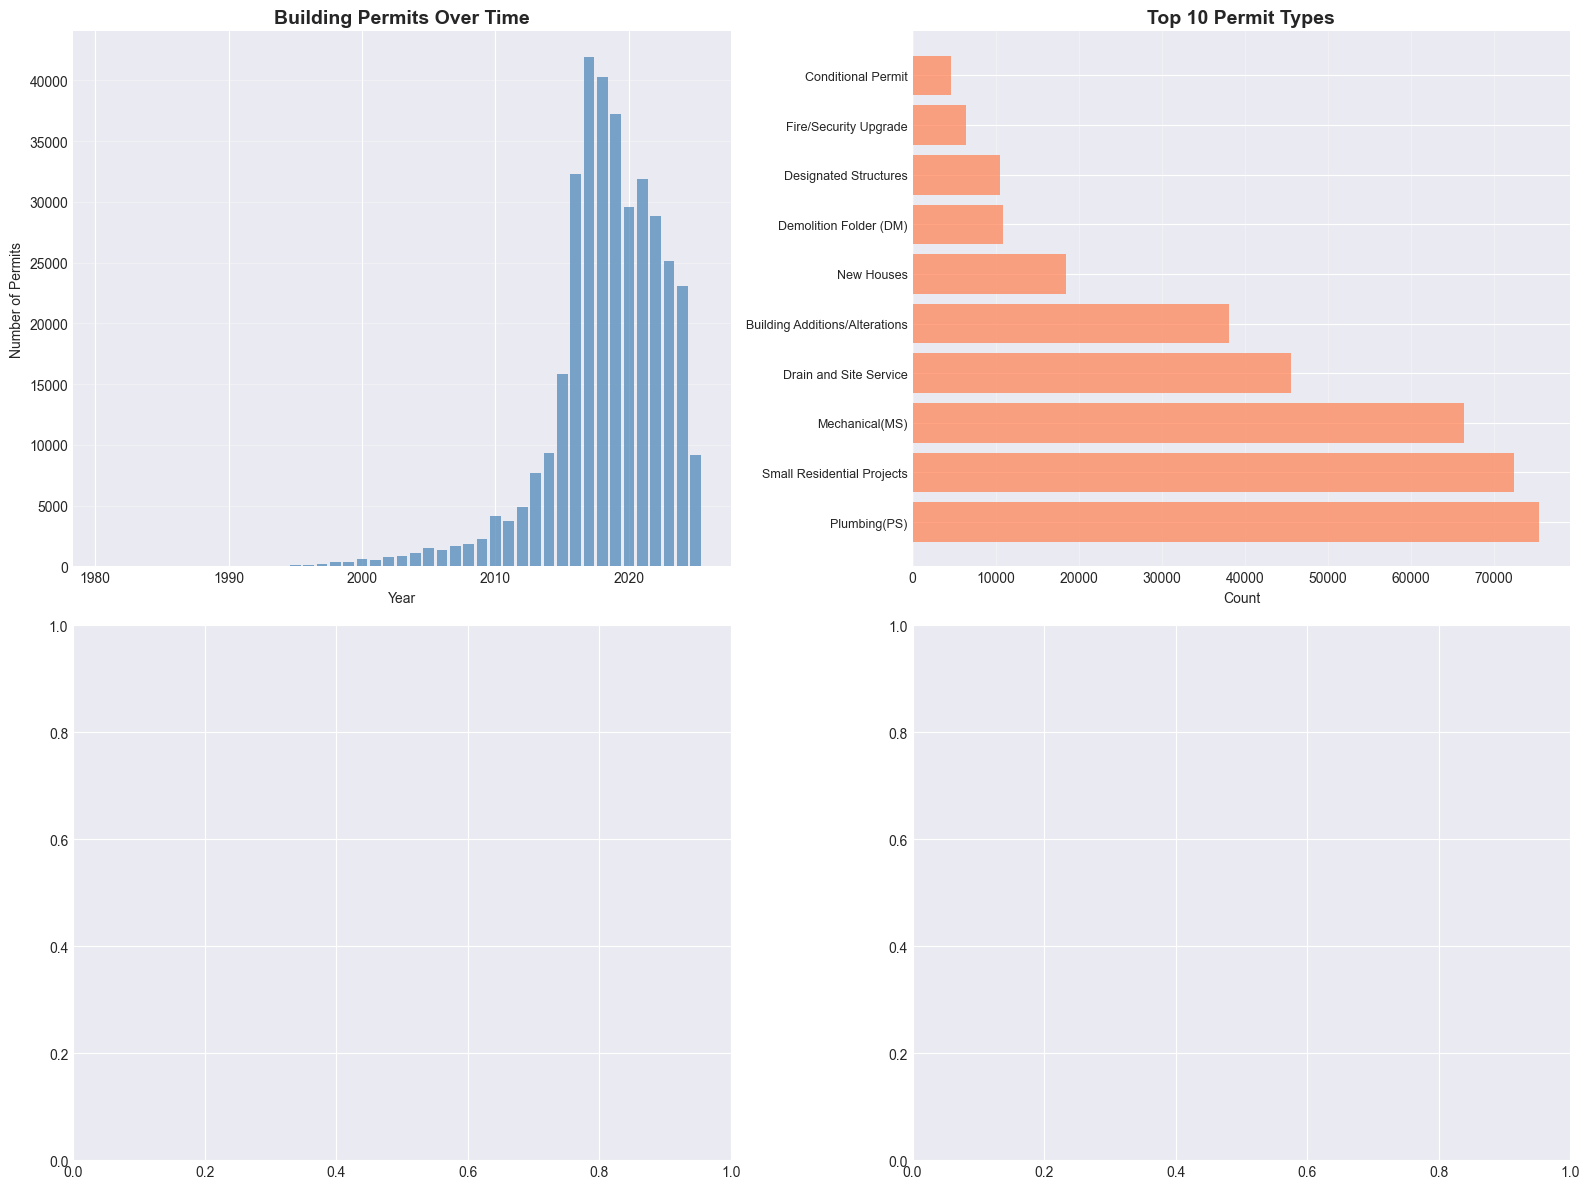


 Figure saved to: /Users/kylewilliamson/Documents/gta-real-estate-hotspots/results/figures/building_permits_analysis.png


In [7]:
if 'df_permits' in locals() and 'Year' in df_permits.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Permits over time
    yearly_permits = df_permits['Year'].value_counts().sort_index()
    axes[0, 0].bar(yearly_permits.index, yearly_permits.values, color='steelblue', alpha=0.7)
    axes[0, 0].set_title('Building Permits Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Number of Permits')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Permit types
    if 'PERMIT_TYPE' in df_permits.columns:
        top_types = df_permits['PERMIT_TYPE'].value_counts().head(10)
        axes[0, 1].barh(range(len(top_types)), top_types.values, color='coral', alpha=0.7)
        axes[0, 1].set_yticks(range(len(top_types)))
        axes[0, 1].set_yticklabels(top_types.index, fontsize=9)
        axes[0, 1].set_title('Top 10 Permit Types', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Count')
        axes[0, 1].grid(True, alpha=0.3, axis='x')
    
    # Plot 3: Construction values over time (if available)
    if 'ESTIMATED_VALUE_NUM' in df_permits.columns:
        yearly_value = df_permits.groupby('Year')['ESTIMATED_VALUE_NUM'].sum() / 1e9  # Convert to billions
        axes[1, 0].plot(yearly_value.index, yearly_value.values, marker='o', linewidth=2, color='green')
        axes[1, 0].set_title('Total Construction Value Over Time', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Year')
        axes[1, 0].set_ylabel('Value (Billions $)')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Value distribution
    if 'ESTIMATED_VALUE_NUM' in df_permits.columns:
        # Filter out extreme outliers for better visualization
        values = df_permits['ESTIMATED_VALUE_NUM'].dropna()
        q99 = values.quantile(0.99)
        values_filtered = values[values <= q99]
        
        axes[1, 1].hist(values_filtered, bins=50, color='purple', alpha=0.7, edgecolor='black')
        axes[1, 1].set_title('Distribution of Construction Values (99th percentile)', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Estimated Value ($)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(RESULTS / 'figures' / 'building_permits_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n Figure saved to: {RESULTS / 'figures' / 'building_permits_analysis.png'}")

## 4. Spatial Visualization - Building Permits Map

Let's create an interactive map showing the geographic distribution of building permits.

In [ ]:
if 'df_permits' in locals():
    print("Creating interactive map of building permits...")
    
    has_coordinates = ('LATITUDE' in df_permits.columns and 
                      'LONGITUDE' in df_permits.columns)

    if not has_coordinates:
        print("No coordinate columns found. Skipping map.")
    else:
    # Filter to valid coordinates within GTA bounds
    # GTA approximate bounds: Lat 43.5-44.0, Lon -79.8 to -79.0
        df_map = df_permits[
            (df_permits['LATITUDE'].notna()) & 
            (df_permits['LONGITUDE'].notna()) &
            (df_permits['LATITUDE'] > 43.5) & 
            (df_permits['LATITUDE'] < 44.0) &
            (df_permits['LONGITUDE'] > -79.8) & 
            (df_permits['LONGITUDE'] < -79.0)
        ].copy()
        
        print(f" Filtered to {len(df_map):,} permits within GTA bounds")
    
        if len(df_map) > 0:
            # For performance, sample if dataset is too large
            if len(df_map) > 5000:
                print(f" Sampling 5,000 permits for map performance")
                df_map = df_map.sample(n=5000, random_state=42)
            
            # Create base map centered on Toronto
            toronto_center = [43.7, -79.4]
            m = folium.Map(
                location=toronto_center,
                zoom_start=11,
                tiles='OpenStreetMap'
            )
            
            # Add marker cluster for better performance
            from folium.plugins import MarkerCluster
            marker_cluster = MarkerCluster(name='Building Permits').add_to(m)
            
            # Add markers
            for idx, row in df_map.iterrows():
                # Create popup text
                popup_text = f"""
                <b>Permit Type:</b> {row.get('PERMIT_TYPE', 'N/A')}<br>
                <b>Date:</b> {row.get('ISSUED_DATE', 'N/A')}<br>
                <b>Value:</b> ${row.get('ESTIMATED_VALUE', 'N/A'):,} <br>
                <b>Building Type:</b> {row.get('PROPOSED_BUILDING_TYPE', 'N/A')}
                """
                
                folium.Marker(
                    location=[row['LATITUDE'], row['LONGITUDE']],
                    popup=folium.Popup(popup_text, max_width=300),
                    icon=folium.Icon(color='blue', icon='info-sign')
                ).add_to(marker_cluster)
            
            # Add layer control
            folium.LayerControl().add_to(m)
            
            # Save map
            map_file = RESULTS / 'figures' / 'permits_map.html'
            m.save(str(map_file))
            
            print(f"\n Interactive map saved to: {map_file}")
            print(f" Open in browser to view: file://{map_file.absolute()}")
            
            # Display in notebook
            display(m)
        else:
            print(" No valid coordinates found for mapping")
else:
    print(" Building permits data or coordinates not available for mapping")

Creating interactive map of building permits...
No coordinate columns found. Skipping map.


NameError: name 'df_map' is not defined

## 5. Data Summary and Export

Let's create summary tables for the midterm report.

In [ ]:
# Create comprehensive summary table
summary_data = []

# Real Estate Summary
if 'df_real_estate' in locals():
    summary_data.append({
        'Data Source': 'Real Estate / Housing',
        'Records': f"{len(df_real_estate):,}",
        'Date Range': f"{df_real_estate['Year'].min()}-{df_real_estate['Year'].max()}" if 'Year' in df_real_estate.columns else 'N/A',
        'Spatial Granularity': 'FSA / Neighbourhood',
        'Status': ' Complete',
        'Notes': f"{df_real_estate.shape[1]} columns"
    })

# Building Permits Summary
if 'df_permits' in locals():
    date_range = 'N/A'
    if 'Year' in df_permits.columns:
        date_range = f"{df_permits['Year'].min()}-{df_permits['Year'].max()}"

    if 'LATITUDE' in df_permits.columns and 'LONGITUDE' in df_permits.columns:
        valid_coords = df_permits[['LATITUDE', 'LONGITUDE']].notna().all(axis=1).sum()
        notes = f"{valid_coords:,} with valid coordinates"
    else:
        notes = f"{len(df_permits):,} total records"
    
    summary_data.append({
        'Data Source': 'Building Permits',
        'Records': f"{len(df_permits):,}",
        'Date Range': date_range,
        'Spatial Granularity': 'Lat/Lon coordinates',
        'Status': ' Complete',
        'Notes': notes
    })

# Demographics (placeholder)
demographics_dir = DATA_RAW / 'demographics'
if demographics_dir.exists() and list(demographics_dir.glob('*.csv')):
    summary_data.append({
        'Data Source': 'Demographics (Census)',
        'Records': 'TBD',
        'Date Range': '2021',
        'Spatial Granularity': 'DA / Neighbourhood',
        'Status': ' In Progress',
        'Notes': 'Data collected, needs processing'
    })
else:
    summary_data.append({
        'Data Source': 'Demographics (Census)',
        'Records': 'N/A',
        'Date Range': 'N/A',
        'Spatial Granularity': 'DA / Neighbourhood',
        'Status': ' Not Started',
        'Notes': 'Pending collection'
    })

# Transit Networks (placeholder)
transit_dir = DATA_RAW / 'transit'
if transit_dir.exists() and list(transit_dir.glob('*.graphml')):
    summary_data.append({
        'Data Source': 'Road Network (OSM)',
        'Records': 'Network Graph',
        'Date Range': '2024',
        'Spatial Granularity': 'Node/Edge level',
        'Status': ' In Progress',
        'Notes': 'Network downloaded'
    })
else:
    summary_data.append({
        'Data Source': 'Road Network (OSM)',
        'Records': 'N/A',
        'Date Range': 'N/A',
        'Spatial Granularity': 'Node/Edge level',
        'Status': ' Not Started',
        'Notes': 'Pending collection'
    })

# Amenities/POIs (placeholder)
amenities_dir = DATA_RAW / 'amenities'
if amenities_dir.exists() and list(amenities_dir.glob('*.geojson')):
    summary_data.append({
        'Data Source': 'Amenities/POIs (OSM)',
        'Records': 'TBD',
        'Date Range': '2024',
        'Spatial Granularity': 'Point locations',
        'Status': ' In Progress',
        'Notes': 'Data collected, needs processing'
    })
else:
    summary_data.append({
        'Data Source': 'Amenities/POIs (OSM)',
        'Records': 'N/A',
        'Date Range': 'N/A',
        'Spatial Granularity': 'Point locations',
        'Status': ' Not Started',
        'Notes': 'Pending collection'
    })

# Create DataFrame
df_summary = pd.DataFrame(summary_data)

print("=" * 80)
print("DATA COLLECTION SUMMARY")
print("=" * 80)
display(df_summary)

# Save to CSV for report
summary_file = RESULTS / 'tables' / 'data_summary.csv'
df_summary.to_csv(summary_file, index=False)
print(f"\n✓ Summary table saved to: {summary_file}")

SyntaxError: unterminated string literal (detected at line 33) (1466201281.py, line 33)

In [ ]:
# Create statistics dictionary for report
from datetime import datetime
import json

stats = {
    'collection_date': datetime.now().strftime('%Y-%m-%d'),
}

if 'summary_data' in locals():
    stats['data_sources_collected'] = len([s for s in summary_data if s['Status'] == 'Complete'])
    stats['total_data_sources'] = len(summary_data)
else:
    stats['data_sources_collected'] = 0
    stats['total_data_sources'] = 0

if 'df_real_estate' in locals():
    stats['real_estate_records'] = len(df_real_estate)
    if 'Year' in df_real_estate.columns:
        stats['real_estate_years'] = f"{df_real_estate['Year'].min()}-{df_real_estate['Year'].max()}"

if 'df_permits' in locals():
    stats['building_permits_records'] = len(df_permits)
    stats['permits_with_coordinates'] = valid_coords
    if 'ESTIMATED_VALUE_NUM' in df_permits.columns:
        stats['total_construction_value_billions'] = round(df_permits['ESTIMATED_VALUE_NUM'].sum() / 1e9, 2)

# Save statistics
import json
stats_file = RESULTS / 'tables' / 'collection_stats.json'
with open(stats_file, 'w') as f:
    json.dump(stats, f, indent=2)

print("=" * 60)
print("KEY STATISTICS")
print("=" * 60)
for key, value in stats.items():
    print(f"{key:40s}: {value}")

print(f"\n✓ Statistics saved to: {stats_file}")

NameError: name 'summary_data' is not defined

## 6. Next Steps

### Completed 
- Data collection from Toronto Open Data (real estate, building permits)
- Initial data quality assessment
- Summary statistics and visualizations
- Interactive spatial maps

### To Do 
1. **Week 2-3 (Network Construction)**
   - Aggregate data to FSA level
   - Build spatial network with adjacency/distance edges
   - Calculate travel times using road network
   - Compute centrality measures

2. **Week 2-3 (Feature Engineering)**
   - Accessibility features (distance to downtown, transit)
   - Amenity density (schools, parks, commercial)
   - Development activity (permit counts and values)
   - Spatial lag features (neighborhood effects)
   - Temporal features (historical growth rates)

3. **Week 4-5 (Baseline Models)**
   - Naive persistence baseline
   - LASSO regression with feature selection
   - XGBoost gradient boosting

4. **Week 6+ (Spatial Models)**
   - Spatial Autoregressive (SAR) model
   - Geographically Weighted Regression (GWR)
   - Graph Convolutional Network (GCN) if time permits

### For Midterm Report
- Include data summary table from Cell 15
- Include key visualizations (Cells 7, 11)
- Document data quality issues and mitigation strategies
- Outline feature engineering plan